# Imports

In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Utilities

In [2]:
def plot_results(images,n_cols = None):
  # Visualizes fake images
  display.clear_output(wait = False)

  n_cols = n_cols or len(images)
  n_rows = (len(images) - 1) // n_cols + 1

  if images.shape[-1] == 1:
    images = np.squeeze(images,axis = -1)

  plt.figure(figsize = (n_cols,n_rows))

  for index,image in enumerate(images):
    plt.subplot(n_rows,n_cols,index + 1)
    plt.imshow(image,cmap = 'binary')
    plt.axis('off')

# Download and Prepare the Dataset

In [4]:
# Download the training images
(X_train,_),_ = tf.keras.datasets.mnist.load_data()

# Normalize pixel values
X_train = X_train.astype('float32') / 255

# Reshape and rescale
X_train = X_train.reshape(-1,28,28,1) * 2. - 1.

BATCH_SIZE = 128

# Create batches of tensors to be fed into the model
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(BATCH_SIZE,drop_remainder = True)

11490434/11490434 [==============================] - 0s 0us/step


# Build the Model

### Generator

In [6]:
codings_size = 32

generator = tf.keras.models.Sequential([
    tf.keras.layers.Dense(7 * 7 * 128,input_shape = [codings_size]),
    # Reshape the output to have three dimensions. This stands for the (length, width, number of filters).
    tf.keras.layers.Reshape([7,7,128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64,kernel_size = 5,strides = 2,padding = 'same',activation = 'selu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1,kernel_size = 5,strides = 2,padding = 'same',activation = 'tanh')
])

generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              206976    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 batch_normalization_2 (Bat  (None, 7, 7, 128)         512       
 chNormalization)                                                
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 14, 14, 64)        204864    
 Transpose)                                                      
                                                                 
 batch_normalization_3 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                      

Shape of the generated batch : (16, 28, 28, 1)


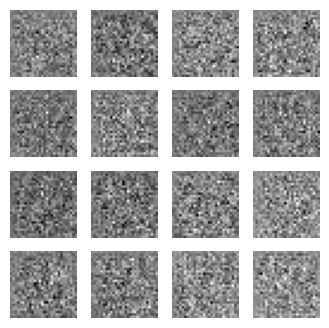

In [9]:
# Generate a batch of noise input (batch_size = 16)
test_noise = tf.random.normal([16,codings_size])

# Feed the batch of the untrained generator
test_image = generator(test_noise)

# Visualize sample output
plot_results(test_image,n_cols = 4)

print(f"Shape of the generated batch : {test_image.shape}")

### Discriminator

In [13]:
discriminator = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64,5,strides = 2,padding = 'same',
                           activation = tf.keras.layers.LeakyReLU(0.2),
                           input_shape = [28,28,1]),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128,5,strides = 2,padding = 'same',
                           activation = tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1,activation = 'sigmoid')
])

discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 212865 (831.50 KB)
Trainable params: 212

In [14]:
gan = tf.keras.models.Sequential([
    generator,
    discriminator
])

# Configure the Model for training

In [15]:
discriminator.compile(
    loss = 'binary_crossentropy',
    optimizer = 'rmsprop'
)
discriminator.trainable = False
gan.compile(
    loss = 'binary_crossentropy',
    optimizer = 'rmsprop'
)

# Train the Model

In [20]:
def train_gan(gan,dataset,random_normal_dimensions,n_epochs = 50):

  generator,discriminator = gan.layers
  for epoch in range(n_epochs):
    print("Epoch {}/{}".format(epoch + 1,n_epochs))
    for real_images in dataset:
      # Infer batch size from the training batch
      batch_size = real_images.shape[0]

      # Train the discriminator - PHASE 1
      # Create the noise
      noise = tf.random.normal(shape = [batch_size,random_normal_dimensions])

      # Use the noise to generate fake images
      fake_images = generator(noise)

      # Create a list by concatenating the fake images with the real ones
      mixed_images = tf.concat([fake_images,real_images],axis = 0)

      # Create the labels for the discriminator
      # 0 - for fake images
      # 1 - for real images
      discriminator_labels = tf.constant(
          [[0.]] * batch_size + [[1.]] * batch_size
      )

      # Ensure that the discriminator is trainale
      discriminator.trainable = True

      # Use train_ob_batch to train the discriminator with the mixed images and the discriminator labels
      discriminator.train_on_batch(mixed_images,discriminator_labels)

      # Train the generator - PHASE 2
      # Create a batch of noise input to feed to the GAN
      noise = tf.random.normal(shape = [batch_size,random_normal_dimensions])

      # Label all generated images to be 'real
      generator_labels = tf.constant([[1.]] * batch_size)

      # Freeze the discriminator
      discriminator.trainable = False

      # Train the GAN on the noise with the labels all set to be true
      gan.train_on_batch(noise,generator_labels)

    # Plot the fake images used to train the generator
    plot_results(fake_images,16)
    plt.show()

In [ ]:
train_gan(gan,dataset,codings_size,100)

Epoch 1/100
